### Introduction

In portuguese [West Region](http://www.perarocha.pt/custompages/showpage.aspx?pageid=33eae525-41ba-481b-b58d-5b686360edfd&m=b26), pear tree cv 'Rocha' is one of the most important crops. Every year, due to climate diferences and yield alternation, production could change a lot, as you can see in the following examples:

* In 2012, 11226 ha produced 116287 metric tons of pears
* In 2013, 12014 ha produced 202483 metric tons of pears

This situation take producers to unexpected costs of transport and chill storage. Furthermore our experience tell us that in low yield years the production tend to be overestimated and in high yield years the production tend to be underestimated.

### Some images and concepts
In [this image](http://www.agronegocios.eu/userfiles/image/dropzone/blogs/20150917092554-perarocha03.jpg) we have two clusters, the left one with two fruits and the right one with one fruit. You can see [some more](http://hortinet.info/wp-content/uploads/perarocha2.png) in this image.

### Disassembling the problem

My idea was to "decompose" the variable that I want to estimate in a product of 5 variables that I can sample easily:

$\frac{yield}{hectare} = \frac{number\,of\,trees}{hectare} \times \frac{number\,of\,branches}{tree} \times \frac{number\,of\,clusters}{branch} \times \frac{number\,of\,fruits}{cluster} \times fruit\;average\;weight$

1. We can know exactly what is the number of trees per hectare, since they are planted with constant distances.
2. After making a groupby the dataframe can give us a count of branches by tree.
3. After making a groupby the dataframe can give us a count of clusters by branch.
4. The number of fruits by cluster was counted and recorded directly.
5. The average weight is measured every year and we can get a good estimate of the variable.

We also tried to collect some measures about tree growth like height and diameter.

I "invited" some coleagues of mine to collect a (I hope) big enough dataset to resample it after and try to find some pattern. By now, I've started by the number of fruits per cluster.

### Importing some libs

In [1]:
import pandas as pd
import numpy as np
import random

from scipy.optimize import curve_fit
from scipy.stats import binom
from scipy.misc import factorial

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Reading the datasets
Datasets were collected at the same time, in the same orchard, but by diferent teams.

In [2]:
df = pd.read_csv('dataset_1.csv') #dataset 1
df2 = pd.read_csv('dataset_2.csv') #dataset 2
dfx = pd.concat([df,df2])

We start analysing the number of fruits per cluster, using the two datasets separately, and then the dataset resulted from joining the firs ones.

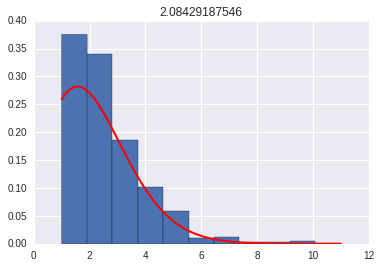

In [3]:
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

data = df.fruit_number
m = np.min(data)
M = np.max(data)
n = np.size(np.unique(data))

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=n, range=[m, M], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(m, M, 100)
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
plt.title(parameters[0])
plt.show()

In [4]:
data.describe()

count    604.000000
mean       2.367550
std        1.551976
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       11.000000
Name: fruit_number, dtype: float64

Here's a Bayesian approach to the same problem.

The `Fruit` class inherits `Update` from `Suite`, and it provides `Likelihood`, which is the likelihood of the data (a sequence of integer counts) under a given hypothesis (the parameter of a Poisson distribution).

It assumes that branches with 0 fruits were not counted, so for each hypothetical Poisson PMF, it sets the probability of 0 fruits to 0 and renormalizes.

In [5]:
import thinkbayes2
import thinkplot

class Fruit(thinkbayes2.Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of `data` under `hypo`.
        
        data: sequence of integer counts
        hypo: parameter of Poisson distribution
        """
        if hypo == 0:
            return 0
        
        pmf = thinkbayes2.MakePoissonPmf(hypo, high=15)
        pmf[0] = 0
        pmf.Normalize()
        
        like = 1
        for count in data:
            like *= pmf[count]
        return like

In order to process all of the data, we have to break it into chunks and renormalize after each chunk.  Otherwise the likelihoods underflow (round down to 0).

In [6]:
def chunks(t, n):
    """Yield successive n-sized chunks from t."""
    for i in range(0, len(t), n):
        yield t[i:i + n]

`prior` is the prior distribution for the parameter.  It is initially uniform over a small range (the range that has non-negligible likelihood).

After the update, the posterior distribution is approximately normal around the MLE.

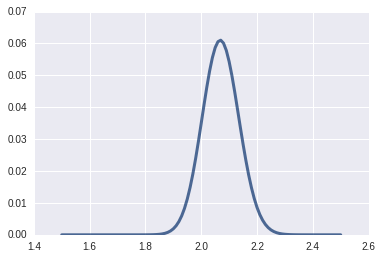

In [7]:
prior = np.linspace(1.5, 2.5, 101)
fruit = Fruit(prior)

for chunk in chunks(data, 100):
    fruit.Update(chunk)

thinkplot.Pdf(fruit)

The posterior mean and MAP (maximum aposteori probability) are both close to 2.1

In [8]:
fruit.Mean(), fruit.MaximumLikelihood()

(2.0700562404217986, 2.0700000000000003)

Now, to compare the model to the data, we have to generate a predictive distribution, which is a mixture of Poisson distributions with different parameters, each one weighted by the posterior probability of the parameter.

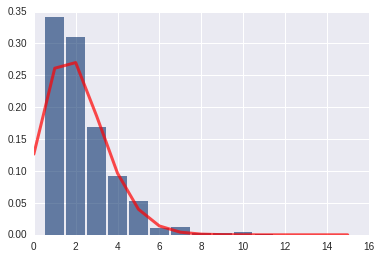

In [9]:
metapmf = thinkbayes2.Pmf()

for hypo, prob in fruit.Items():
    pmf = thinkbayes2.MakePoissonPmf(hypo, high=15)
    metapmf[pmf] = prob
    
mix = thinkbayes2.MakeMixture(metapmf)

data_pmf = thinkbayes2.Pmf(data)
thinkplot.Hist(data_pmf)

thinkplot.Pdf(mix, color='red')

The model is a pretty good match for the data, and not wildly different from the estimate by curve fitting.

So that's one of the steps we talked about -- making a Bayesian estimate based on the assumption that the 0-fruit branches were not measured.

I hope to get to some of the other steps soon!

-- Allen

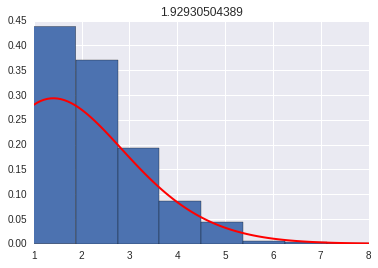

In [10]:
data = df2.fruit_number
m = np.min(data)
M = np.max(data)
n = np.size(np.unique(data))

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=n, range=[m, M], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(m, M, 100)
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
plt.title(parameters[0])
plt.show()

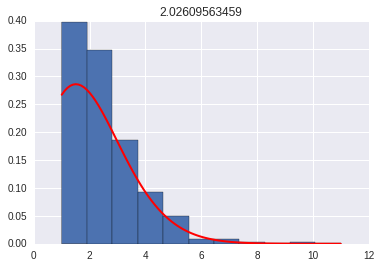

In [11]:
data = dfx.fruit_number
m = np.min(data)
M = np.max(data)
n = np.size(np.unique(data))

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=n, range=[m, M], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(m, M, 100)
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
plt.title(parameters[0])
plt.show()

After that I made some resample and calculated the $\lambda$ factor of the adjusted distribution for each resample.

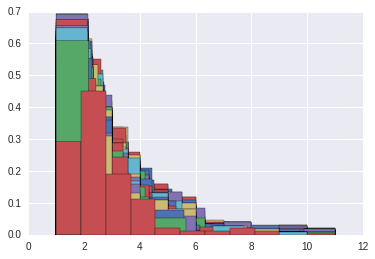

In [12]:
ixto =[]
for i in range(1,1000):

    data = dfx.fruit_number.sample(n=100)
    m = np.min(data)
    M = np.max(data)
    n = np.size(np.unique(data))

    # the bins should be of integer width, because poisson is an integer distribution
    entries, bin_edges, patches = plt.hist(data, bins=n, range=[m, M], normed=True)
    
    # calculate binmiddles
    bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
    
    # fit with curve_fit
    parameters, cov_matrix = curve_fit(poisson, bin_middles, entries)
    ixto.append(parameters[0])

(array([  3.,   2.,   2.,   8.,   4.,   6.,  16.,  11.,  15.,  19.,  14.,
         22.,  19.,  21.,  21.,  24.,  22.,  11.,  14.,  15.,  10.,   9.,
         13.,   8.,  14.,  13.,   5.,   3.,   9.,  14.,  10.,  13.,  11.,
         12.,  10.,  17.,  13.,  16.,  11.,  18.,  12.,  16.,  19.,  15.,
         14.,  14.,  22.,  12.,  15.,  11.,  13.,  11.,  14.,  15.,   9.,
         14.,  15.,  10.,  17.,  14.,  15.,  14.,  13.,   8.,  16.,  13.,
         11.,   6.,   8.,   6.,   6.,   6.,  10.,   7.,   6.,   7.,  11.,
          4.,   7.,   7.,   2.,   4.,   3.,   3.,   2.,   1.,   0.,   2.,
          3.,   3.,   3.,   2.,   0.,   2.,   2.,   1.,   2.,   0.,   1.,
          2.]),
 array([ 1.44749516,  1.45846755,  1.46943994,  1.48041233,  1.49138472,
         1.50235711,  1.5133295 ,  1.52430189,  1.53527428,  1.54624666,
         1.55721905,  1.56819144,  1.57916383,  1.59013622,  1.60110861,
         1.612081  ,  1.62305339,  1.63402578,  1.64499817,  1.65597055,
         1.66694294,  1.67

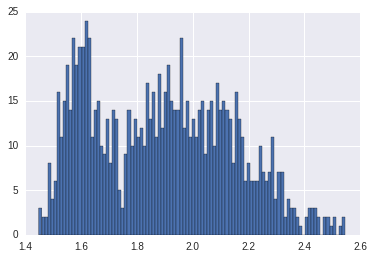

In [13]:
plt.hist(ixto, bins=100)

I've noticed a bi-modal distribution... That's the begining of a long walk and I would like to have your help to find that is possible to reduce our sample sizes.